In [1]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
# load data for viscous Burger's equation
df = pd.read_csv('full-order_sol.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,27665,27666,27667,27668,27669,27670,27671,27672,27673,27674
0,1.224647e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,6.135885e-03,0.006115,0.006093,0.006071,0.006049,0.006026,0.006004,0.005982,0.005960,0.005939,...,0.001227,0.001226,0.001225,0.001224,0.001223,0.001222,0.001221,0.001220,0.001219,0.0
2,1.227154e-02,0.012228,0.012184,0.012139,0.012095,0.012050,0.012006,0.011962,0.011918,0.011875,...,0.002454,0.002452,0.002450,0.002448,0.002446,0.002444,0.002442,0.002441,0.002439,0.0
3,1.840673e-02,0.018340,0.018273,0.018206,0.018139,0.018072,0.018006,0.017939,0.017874,0.017808,...,0.003681,0.003678,0.003675,0.003672,0.003669,0.003666,0.003664,0.003661,0.003658,0.0
4,2.454123e-02,0.024451,0.024360,0.024271,0.024181,0.024092,0.024003,0.023915,0.023827,0.023740,...,0.004907,0.004904,0.004900,0.004896,0.004892,0.004888,0.004885,0.004881,0.004877,0.0


In [3]:
# dimension of full order solution
df.shape

(1025, 27675)

In [4]:
Mu = np.arange(1,7.75,0.25)
Mu.shape

(27,)

In [5]:
row = []
for i in range(df.shape[0]):
    if i%4 == 0:
        row.append(i)

col = []
for j in range(df.shape[1]):
    if j%4 == 0:
        col.append(j)

print(len(row))
print(len(col))

257
6919


In [6]:
S = df.iloc[row,col]
S.shape

(257, 6919)

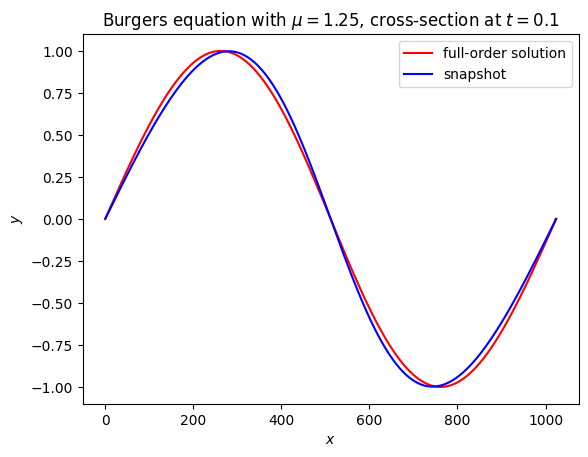

In [7]:
plt.plot(df.iloc[:,10],'r',label='full-order solution')
plt.plot(S.iloc[:,10],'b', label='snapshot')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title('Burgers equation with $\mu = 1.25$, cross-section at $t=0.1$')
plt.legend()

## 1. RB 

In [8]:
from scipy.linalg import svd

def RB(S,L):
    ### Inputs:
    # S: snapshots of size (N_h x N_s)
    # L: rank of approximation solution, L << min(N_h, N_s)

    ### Outputs:,
    # V: first L columns of U, where S = UAZ'
    # Q: collection of coefficient associated with column bases of V
    # U_rb: the reduced order solution
    
    U, s, VT = svd(S)
    
    V = U[0:S.shape[0],0:L]
    print(V.shape)
    Q = V.T @ S
    print(Q.shape)
    U_rb = V @ Q
    print(U_rb.shape)
    
    D = np.diag(s)**2
    print(sum(s))
    # display projection error
    print('projection error =', sum(s[L:s.shape[0]]))
    
    return(V, Q, U_rb)

In [9]:
V, Q, U_rb = RB(S, L = 10) # approximation rank = 10

(257, 10)
(10, 6919)
(257, 6919)
904.1158528835741
projection error = 0.9482765231334919


In [10]:
V, Q, U_rb = RB(S, L = 7) # approximation rank = 7

(257, 7)
(7, 6919)
(257, 6919)
904.1158528835741
projection error = 3.5147763680418795


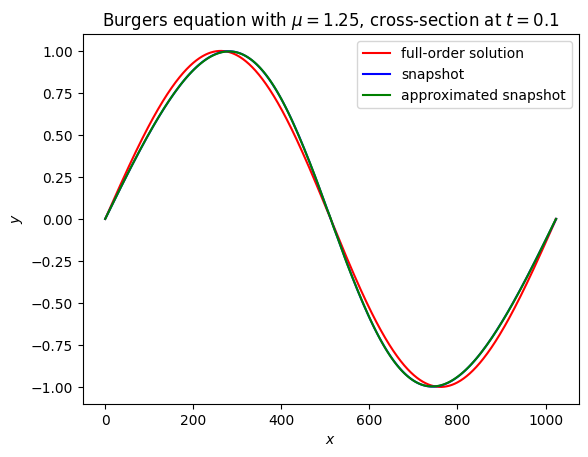

In [27]:
plt.plot(df.iloc[:,10],'r',label='full-order solution')
plt.plot(S.iloc[:,10],'b', label='snapshot')
plt.plot(np.array(row),U_rb.iloc[:,10],'g', label='approximated snapshot')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title('Burgers equation with $\mu = 1.25$, cross-section at $t=0.1$')
plt.legend()
plt.savefig('Burgers_mu_1.25_t=0.1.png')
plt.show()

## Construct data to train regression model

In [18]:
S

,0,4,8,12,16,20,24,28,32,36,...,27636,27640,27644,27648,27652,27656,27660,27664,27668,27672
0,1.224647e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2.454123e-02,0.024181,0.023827,0.023481,0.023145,0.022817,0.022498,0.022187,0.021885,0.021590,...,0.005020,0.005004,0.004988,0.004973,0.004957,0.004942,0.004926,0.004911,0.004896,0.004881
8,4.906767e-02,0.048334,0.047621,0.046928,0.046254,0.045598,0.044960,0.044339,0.043735,0.043147,...,0.010040,0.010008,0.009976,0.009945,0.009914,0.009883,0.009853,0.009822,0.009792,0.009762
12,7.356456e-02,0.072457,0.071383,0.070340,0.069327,0.068343,0.067386,0.066455,0.065550,0.064668,...,0.015059,0.015011,0.014964,0.014917,0.014871,0.014824,0.014778,0.014733,0.014687,0.014642
16,9.801714e-02,0.096538,0.095104,0.093713,0.092362,0.091049,0.089774,0.088534,0.087327,0.086153,...,0.020078,0.020014,0.019951,0.019889,0.019827,0.019765,0.019704,0.019643,0.019582,0.019522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,-9.801714e-02,-0.096502,-0.095037,-0.093627,-0.092271,-0.090961,-0.089692,-0.088461,-0.087264,-0.086099,...,-0.018999,-0.018939,-0.018879,-0.018820,-0.018761,-0.018703,-0.018644,-0.018587,-0.018529,-0.018472
1012,-7.356456e-02,-0.072423,-0.071344,-0.070323,-0.069340,-0.068385,-0.067454,-0.066546,-0.065659,-0.064794,...,-0.013987,-0.013943,-0.013899,-0.013855,-0.013812,-0.013769,-0.013726,-0.013684,-0.013641,-0.013599
1016,-4.906767e-02,-0.048344,-0.047729,-0.047119,-0.046507,-0.045897,-0.045293,-0.044698,-0.044114,-0.043541,...,-0.008975,-0.008947,-0.008919,-0.008891,-0.008863,-0.008835,-0.008808,-0.008781,-0.008753,-0.008726
1020,-2.454123e-02,-0.024551,-0.024376,-0.024117,-0.023829,-0.023532,-0.023231,-0.022933,-0.022637,-0.022347,...,-0.003964,-0.003951,-0.003939,-0.003926,-0.003914,-0.003902,-0.003890,-0.003878,-0.003866,-0.003854


In [31]:
n = len(row) #257
y = []
t = []
for i in range(len(Mu)-1):
    # print(i)
    S_i = np.array(S.iloc[:,257*i:257*(i+1)])
    # print(np.reshape(S_i, 257*257,order='F'))
    for j in range(n):
        # print(S_i[j])
        y.append(S_i[j])
        t.append(j*4*(1/1024))

In [12]:
n = len(row) #257
y = []
t = []
for i in range(len(Mu)-1):
    # print(i)
    S_i = np.array(S.iloc[:,257*i:257*(i+1)])
    # print(np.reshape(S_i, 257*257,order='F'))
    y.append(np.reshape(S_i, 257*257,order='F'))
    t.append(list(row)*257)

In [13]:
t = np.array(t)
y = np.array(y)

In [32]:
# Train GPR for different instance of mu
rng = np.random.RandomState(13)
training_indices = rng.choice(np.arange(26), size=int(0.8*26), replace=False)
print(training_indices)
#X_train = np.concatenate((Mu[training_indices].reshape(-1,1),t[training_indices*257]),axis=1)
#y_train = y[training_indices]

[ 8 19  1 11 15  7 22 25  0 17  4  9 23 13  5 21 14 20  3 12]


In [37]:
def train_loader(S,train_indices):
    n = len(row) #257
    y_train = []
    X_train = []
    for i in training_indices:
        # print(i)
        S_i = np.array(S.iloc[:,257*i:257*(i+1)])
        # print(np.reshape(S_i, 257*257,order='F'))
        for j in range(n):
            # print(S_i[j])
            y_train.append(S_i[:,j])
            X_train.append(np.array([Mu[i],j*4*(1/1024)]))
    return (X_train, y_train)

In [ ]:
X_train, y_train = train_loader(S,train_indices)

In [39]:
X_train[0]

array([3., 0.])

In [38]:
y_train[0]

array([ 0.00000000e+00,  2.24238399e-02,  4.48270705e-02,  6.72017223e-02,
        8.95395001e-02,  1.11831733e-01,  1.34069365e-01,  1.56242991e-01,
        1.78342909e-01,  2.00359194e-01,  2.22281759e-01,  2.44100418e-01,
        2.65804925e-01,  2.87385006e-01,  3.08830376e-01,  3.30130756e-01,
        3.51275871e-01,  3.72255463e-01,  3.93059290e-01,  4.13677125e-01,
        4.34098764e-01,  4.54314024e-01,  4.74312744e-01,  4.94084789e-01,
        5.13620052e-01,  5.32908454e-01,  5.51939949e-01,  5.70704523e-01,
        5.89192198e-01,  6.07393038e-01,  6.25297145e-01,  6.42894665e-01,
        6.60175795e-01,  6.77130779e-01,  6.93749915e-01,  7.10023560e-01,
        7.25942130e-01,  7.41496107e-01,  7.56676040e-01,  7.71472553e-01,
        7.85876346e-01,  7.99878201e-01,  8.13468986e-01,  8.26639663e-01,
        8.39381289e-01,  8.51685023e-01,  8.63542135e-01,  8.74944006e-01,
        8.85882139e-01,  8.96348163e-01,  9.06333842e-01,  9.15831079e-01,
        9.24831924e-01,  

In [40]:
test_indices = np.delete(np.arange(len(Mu)-1),training_indices)
print(test_indices)

[ 2  6 10 16 18 24]


In [46]:
def test_loader(S,test_indices):
    n = len(row) #257
    y_test = []
    X_test = []
    for i in test_indices:
        # print(i)
        S_i = np.array(S.iloc[:,257*i:257*(i+1)])
        # print(np.reshape(S_i, 257*257,order='F'))
        for j in range(n):
            # print(S_i[j])
            y_test.append(S_i[:,j])
            X_test.append(np.array([Mu[i],j*4*(1/1024)]))
    return (X_test, y_test)

In [47]:
X_test, y_test = test_loader(S,test_indices)

In [66]:
len(X_train)

5140

In [67]:
y_train.shape

(5140, 257)

### Make predictions with GPR

In [158]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

0.396**2 * RBF(length_scale=0.383)

In [256]:
def plot_GPR_full(tt,mu,timestamp,n_mu):
    X = np.concatenate((np.array([mu]),tt)).reshape(1,-1)
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    #print(std_prediction)
    
    mean = mean_prediction.reshape(257,257)[timestamp]
    #print(mean.shape)
    
    plt.plot(df.iloc[:,timestamp+1024*n_mu],'r',label='full-order solution')
    # plt.plot(S.iloc[:,10],'b', label='snapshot')
    t = np.array(row)
    plt.plot(t,U_rb.iloc[:,timestamp+257*n_mu],'y', label='approximated snapshot')
    # plt.plot(X, y, label="learned snapshot", linestyle="dotted")
    # plt.scatter(X_train, y_train, label="Observations")
 
    plt.plot(t, mean, label="regression mean prediction",linestyle="dotted")
    plt.fill_between(
        t.ravel(),
        mean - 1.96 * std_prediction,
        mean + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$u$")
    _ = plt.title(f"Gaussian process regression on noise-free dataset with $\mu=${mu}")

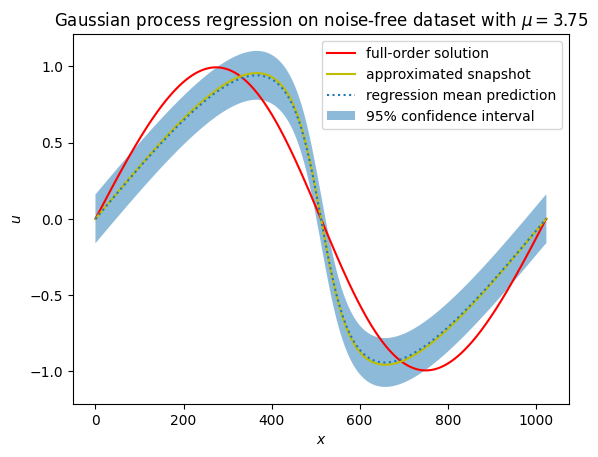

In [257]:
tt = t[0]
plot_GPR_full(tt,mu=Mu[11],timestamp=40,n_mu=11)

## 3. Train a neural network

#### Train (Offline)
Input:
- Collection of snapshot $S$
- Values of parameter $\mu$

Output:
- Orthogonal bases $V$ of rank $L$
- Regression model $\hat{q}(·; ·)$

$\rightarrow$ Model: Single-layer fully connected neural network

$\rightarrow$ Parameters:
* Hidden dimension: 1000
* Input: ($\mu$,$t$) (dim=2)
* Output: reduced-basis solution (dim=257)

#### Inference (Online)
Input:
- New value ($\mu$,$t$)

Output
- Reduced-basis solution of $u$ depends on $x$

In [124]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from typing import Optional, List, Tuple, Dict


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [116]:
class SingleLayerMLP(nn.Module):
    """constructing a single layer neural network with Pytorch"""
    def __init__(self, indim, outdim, hidden_layer=100):
        super(SingleLayerMLP, self).__init__()
        self.hidden_layer = nn.Linear(indim, hidden_layer)
        self.output = nn.Linear(hidden_layer, outdim)
        self.activation = nn.ReLU()


    def forward(self, x):
        """
        x shape (batch_size, input_dim)
        """
        x = x.to(self.hidden_layer.weight.dtype)
        hidden = self.hidden_layer(x)
        activate = self.activation(hidden)
        output = self.output(activate)
        return output
    


class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx, :]
        return (x, y)

    def __len__(self):
        return self.length


def validate(model, loader, loss_fnc, optimizer):
    """takes in a dataloader, then returns the model loss and accuracy on this loader"""
    
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_samples = 0
        
        model.eval()
        for x, y in loader:
            x, y = x.to(device), y.to(device).float()
            outputs = model(x)
            loss = loss_fnc(outputs, y)
            total_loss += loss.item() * x.shape[0]
            #predictions = outputs.argmax(dim=1)
            #total_correct += (predictions == y).sum().item()
            total_samples += x.shape[0]
            
        # Calculate the average loss and accuracy
        average_loss = total_loss / total_samples
        #average_accuracy = total_correct / total_samples

        return average_loss #, average_accuracy


def train(model, train_loader, criterion, optimizer):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).float()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.shape[0]
        #predictions = outputs.argmax(dim=1)
        #total_correct += (predictions == y).sum().item()
        total_samples += x.shape[0]

    # Calculate the average loss and accuracy
    average_loss = total_loss / total_samples
    #average_accuracy = total_correct / total_samples

    return average_loss #, average_accuracy

In [118]:
if __name__ == "__main__":

    indim = 2
    outdim = 257
    hidden_dim = 1000
    lr = 0.01
    batch_size = 2
    epochs = 100

    #dataset
    Xtrain = np.array(X_train) # np.loadtxt("data/XTrain.txt", delimiter="\t")
    Ytrain = np.array(y_train) # np.loadtxt("data/yTrain.txt", delimiter="\t").astype(int)
    m1, n1 = Xtrain.shape
    print(m1, n1)
    train_ds = DS(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size)

    Xtest = np.array(X_test) # np.loadtxt("data/XTest.txt", delimiter="\t")
    Ytest = np.array(y_test) # np.loadtxt("data/yTest.txt", delimiter="\t").astype(int)
    m2, n2 = Xtest.shape
    print(m1, n2)
    test_ds = DS(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    #construct the model
    model = SingleLayerMLP(indim, outdim, hidden_dim).to(device)

    # Define the loss function
    loss_fnc = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    #construct the training process
    #train_losses, train_accs, test_losses, test_accs = [], [], [], []
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        # Train the model
        train_loss = train(model, train_loader, loss_fnc, optimizer)
        train_losses.append(train_loss)
        #train_accs.append(train_acc)

        # Evaluate the model on the test set
        test_loss = validate(model, test_loader, loss_fnc, optimizer)
        test_losses.append(test_loss)
        #test_accs.append(test_acc)

        # Print the results for this epoch
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

5140 2
5140 2
Epoch 1: Train Loss=0.0202, Test Loss=0.0592
Epoch 2: Train Loss=0.0127, Test Loss=0.0460
Epoch 3: Train Loss=0.0107, Test Loss=0.0401
Epoch 4: Train Loss=0.0098, Test Loss=0.0368
Epoch 5: Train Loss=0.0093, Test Loss=0.0348
Epoch 6: Train Loss=0.0091, Test Loss=0.0334
Epoch 7: Train Loss=0.0089, Test Loss=0.0323
Epoch 8: Train Loss=0.0088, Test Loss=0.0314
Epoch 9: Train Loss=0.0087, Test Loss=0.0305
Epoch 10: Train Loss=0.0087, Test Loss=0.0298
Epoch 11: Train Loss=0.0086, Test Loss=0.0291
Epoch 12: Train Loss=0.0085, Test Loss=0.0285
Epoch 13: Train Loss=0.0085, Test Loss=0.0280
Epoch 14: Train Loss=0.0084, Test Loss=0.0274
Epoch 15: Train Loss=0.0084, Test Loss=0.0270
Epoch 16: Train Loss=0.0083, Test Loss=0.0265
Epoch 17: Train Loss=0.0083, Test Loss=0.0261
Epoch 18: Train Loss=0.0082, Test Loss=0.0257
Epoch 19: Train Loss=0.0082, Test Loss=0.0253
Epoch 20: Train Loss=0.0081, Test Loss=0.0249
Epoch 21: Train Loss=0.0081, Test Loss=0.0246
Epoch 22: Train Loss=0.0080, 

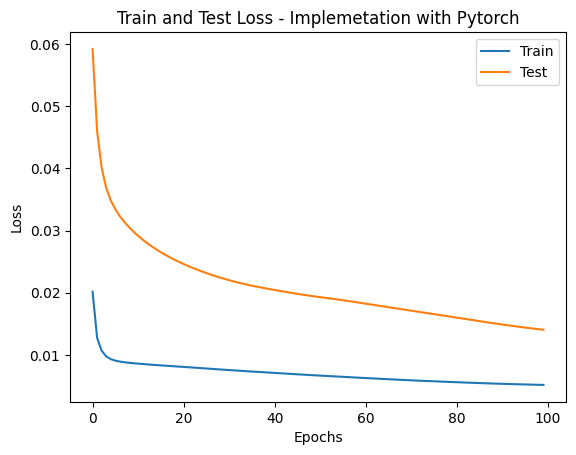

In [119]:
# plot training and testing losses
plt.plot(np.arange(epochs), np.array(train_losses), label="Train")
plt.plot(np.arange(epochs), np.array(test_losses), label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train and Test Loss - Implemetation with Pytorch')
plt.legend()
plt.savefig('nn_loss2.png')
plt.show()

In [128]:
def plot_nn_full(tt,mu,timestamp,n_mu):
    X = np.array([mu,tt])
    X = torch.tensor(X).float()
    print(X)
    prediction = model(X)
    #print(std_prediction)
    
    pred = prediction #.reshape(257,257)[timestamp]
    #print(mean.shape)
    
    plt.plot(df.iloc[:,(timestamp+256*n_mu)*4],'r',label='full-order solution')
    # plt.plot(S.iloc[:,10],'b', label='snapshot')
    t = np.array(row)
    plt.plot(t,U_rb.iloc[:,(timestamp+256*n_mu)],'y', label='approximated snapshot')
    # plt.plot(X, y, label="learned snapshot", linestyle="dotted")
    # plt.scatter(X_train, y_train, label="Observations")
 
    plt.plot(t, pred.detach().numpy(), label="Neural network regression prediction") #,linestyle="dotted")
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$u$")
    _ = plt.title(f"Neural network regression on noise-free dataset with $\mu=${mu}")
    plt.savefig(f'NN_rb_mu={mu}.png')
    plt.show

In [126]:
test_indices

array([ 2,  6, 10, 16, 18, 24])

In [127]:
tt = t[0]
print(tt)
#plot_nn_full(tt,mu=Mu[16],timestamp=40,n_mu=16)

0.0


tensor([5., 0.])


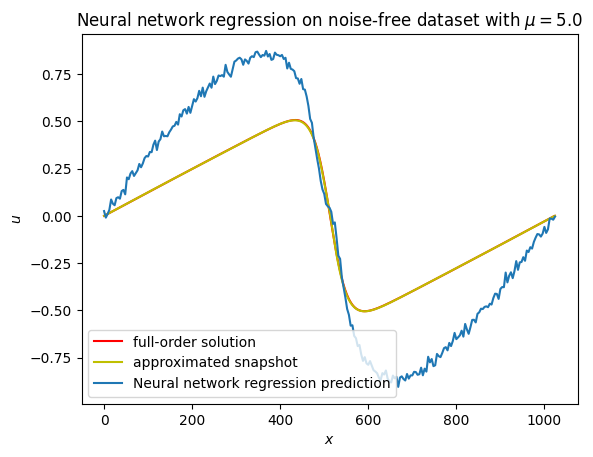

In [129]:
plot_nn_full(tt,mu=Mu[16],timestamp=0,n_mu=16)